In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=df902e5a3e5bb808ae800b49904924ac35778fc11a4bea87967e81b48e5b45fb
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [5]:
# Initializing helper functions

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from pyspark.context import SparkContext, SparkConf
from sklearn.metrics import pairwise_distances
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType, FloatType
from sklearn.metrics import silhouette_score

def parse_vector(line):
  return np.array([int(x) for x in line.split(' ')])

def closest_point(p,centers):
  bestIndex = 0
  closest = float('+inf')
  for i in range(len(centers)):
    tempDist = np.sum((p - centers[i])**2)
    if tempDist < closest :
      closest = tempDist
      bestIndex = i
  return bestIndex

def visualize(clustered, label, caption):
    unique_labels = set(x[0] for x in clustered)
    num_labels = len(unique_labels)
    colors = cm.rainbow(np.linspace(0, 1, num_labels))
    label_color_map = dict(zip(unique_labels, colors))
    x_coords = []
    y_coords = []
    labels = []
    for (iK, p) in clustered:
        x_coords.append(p[0][0])
        y_coords.append(p[0][1])
        labels.append(iK)
    plt.scatter(np.array(x_coords), np.array(y_coords), c=[label_color_map[label] for label in labels])
    plt.title(label)
    plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

def WSSE(clustered, centroids):
  clustered = sc.parallelize(clustered)
  return clustered.map(lambda point: (1, np.sum((centroids[point[0]] - point[1][0]) ** 2))).reduceByKey(lambda x,y: x + y).map(lambda x: x[1]).sum()

def BSSE(centroids):
  centroids = sc.parallelize(centroids)
  mean_centroid = centroids.map(lambda point: (1, ((point[0], point[1]), 1))).reduceByKey(lambda x,y: ((x[0][0] + y[0][0], x[0][1] + y[0][1]), x[1] + y[1])).map(lambda x: (x[1][0][0]/x[1][1], x[1][0][1]/x[1][1])).collect()[0]
  return centroids.map(lambda point: (1, np.sum((mean_centroid - point) ** 2))).reduceByKey(lambda x,y: x + y).map(lambda x: x[1]).sum()

def SSE(clustered, centroids, centroid):
    sum_val = 0
    for point in clustered:
        c1 = np.array(centroids[point[0]])
        c2 = np.array(centroid)
        if (c1 == c2).all():
            sum_val += np.sum((centroids[point[0]] - point[1][0]) ** 2)
    return sum_val

def helper_silhouette(point, clustered):
    cluster_index = point[0]
    pt = point[1][0][0], point[1][0][1]

    same = list(filter(lambda p: p[0] == cluster_index, clustered))
    same = np.sum(np.array([np.sum((p[1][0] - pt) ** 2) for p in same])) / (len(same) - 1)

    diff = list(filter(lambda p: p[0] != cluster_index, clustered))
    diff = np.sum(np.array([np.sum((p[1][0] - pt) ** 2) for p in diff])) / (len(diff) - 1)

    silhouette_point = (diff - same) / max(same, diff)
    return silhouette_point

def correct_silhouette(clustered, centroids):
    clustered_rdd = sc.parallelize(clustered)
    silhouette_sum = clustered_rdd.map(lambda point: helper_silhouette(point, clustered)).sum()
    silhouette_avg = silhouette_sum / clustered_rdd.count()
    return silhouette_avg

sc = SparkContext.getOrCreate()
ss = SparkSession.builder.getOrCreate()
data = sc.textFile(('DS1.txt')).map(lambda x: parse_vector(x))
data.persist()

PythonRDD[67] at RDD at PythonRDD.scala:53

In [ ]:
def k_means(data, K, centroids=[]):
    converge_dist = float(0.2)
    k_points = centroids
    if len(centroids) == 0:
        k_points = data.takeSample(False, K)
    temp_dist = 1
    while temp_dist > converge_dist:
        closest = data.map(lambda p: (closest_point(p, k_points), (p, 1)))
        point_stats = closest.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
        new_points = point_stats.map(lambda pair: (pair[0], pair[1][0] / pair[1][1])).collect()
        temp_dist = sum(np.sum((k_points[iK] - p) ** 2) for (iK, p) in new_points)
        for (iK, p) in new_points:
            k_points[iK] = p
    return closest.collect(), k_points

In [126]:
def bisecting_k_means(data, K):
    filtered = data.collect()
    bisecting_centroids = []
    while len(bisecting_centroids) != K:
        if len(bisecting_centroids) != 0:
            clustered, centroids = k_means(data, len(bisecting_centroids), bisecting_centroids)
            clustered = sc.parallelize(clustered)
            k = -1
            sse = float('-inf')
            for i in range(len(bisecting_centroids)):
                new_sse = SSE(clustered.collect(), centroids, bisecting_centroids[i])
                if new_sse > sse:
                    sse = new_sse
                    k = i
            filtered = clustered.filter(lambda item: item[0] == k).map(lambda item: item[1][0]).collect()
            bisecting_centroids.pop(k)
        clustered_help, centroids_help = k_means(sc.parallelize(filtered), 2)
        bisecting_centroids.append(centroids_help[0])
        bisecting_centroids.append(centroids_help[1])
    clustered, centroids = k_means(data, len(bisecting_centroids), bisecting_centroids)
    return clustered, centroids

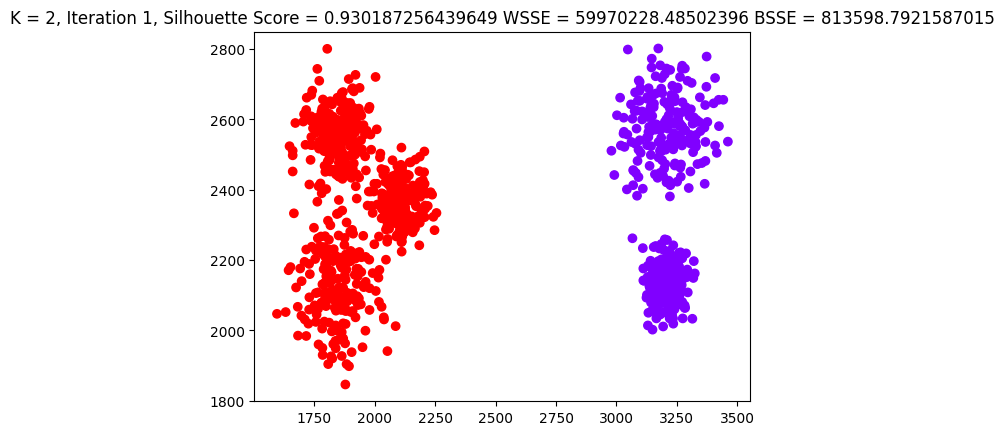

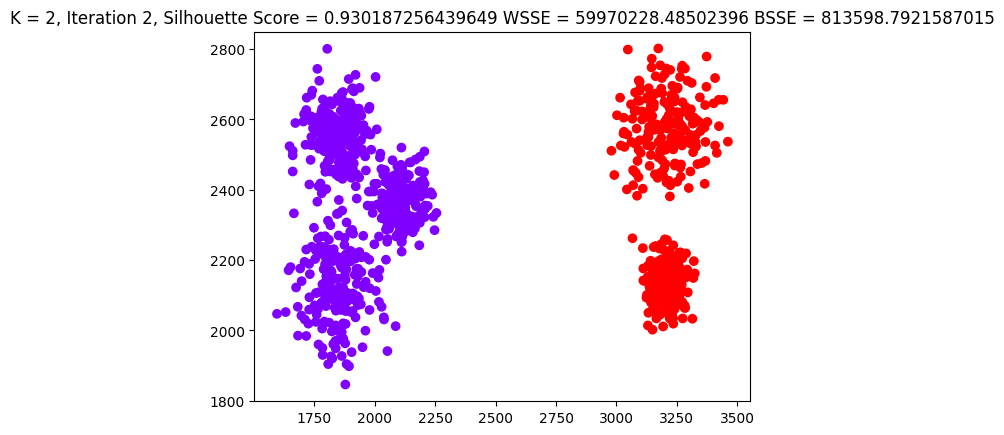

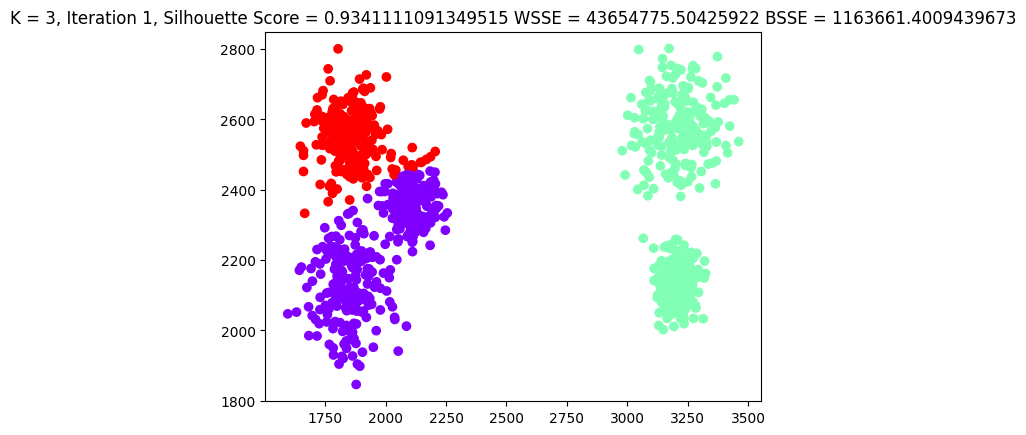

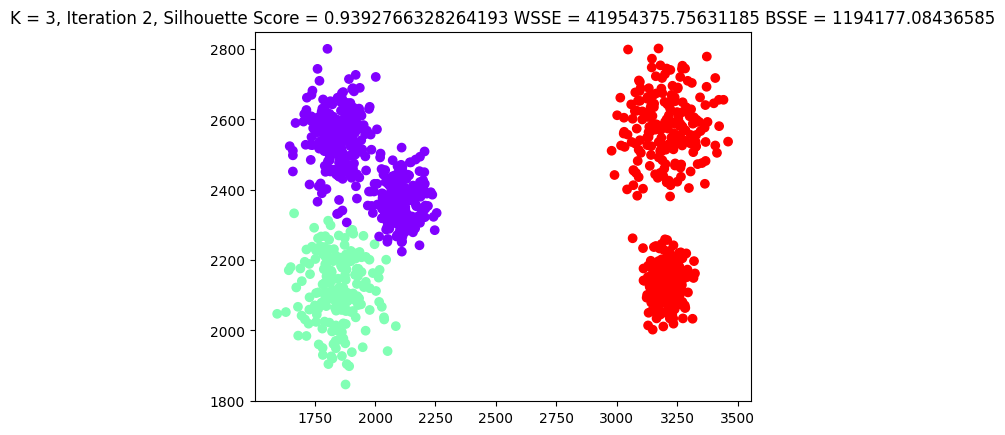

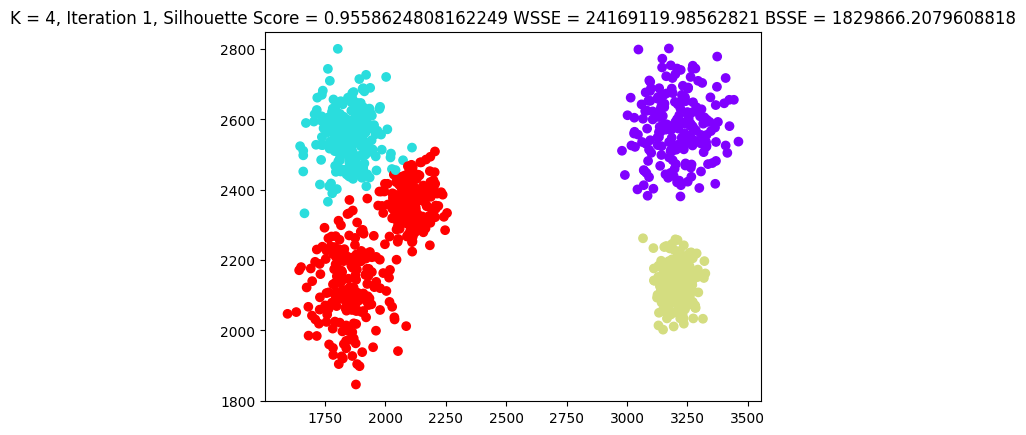

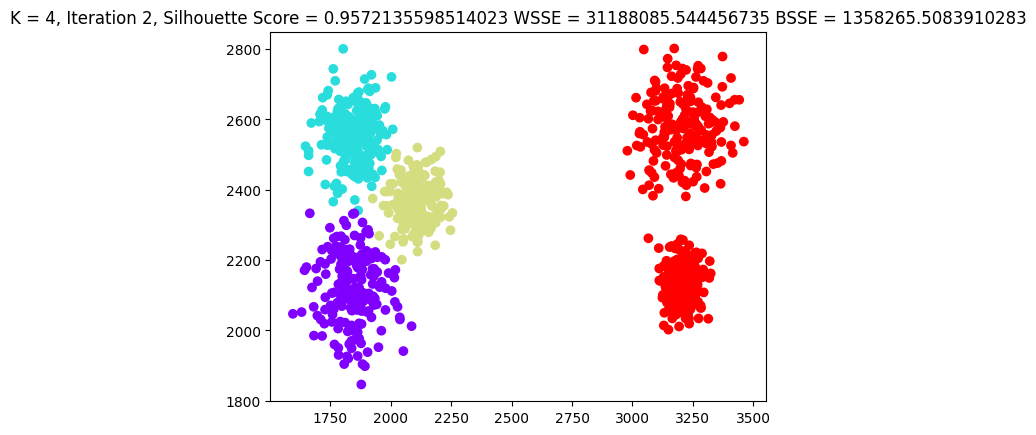

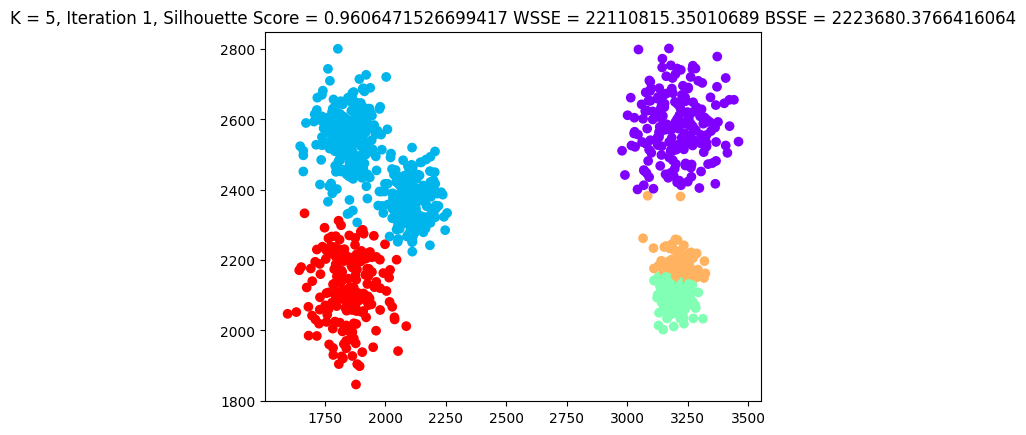

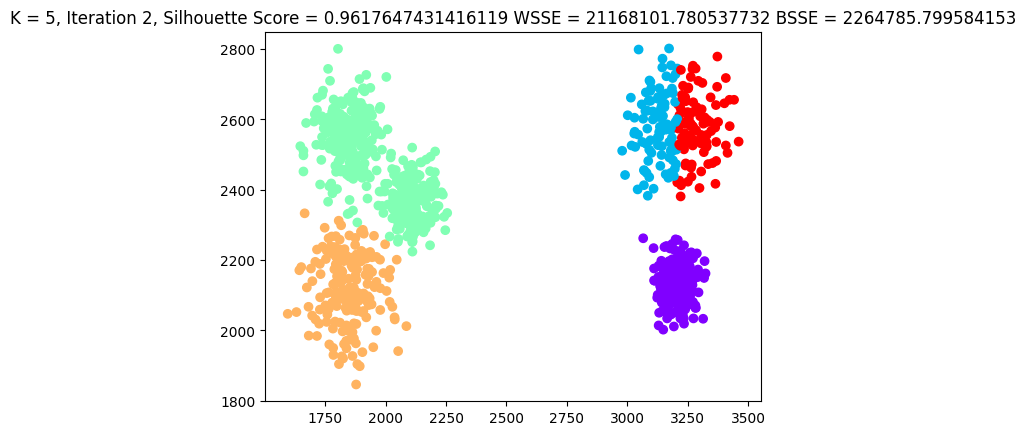

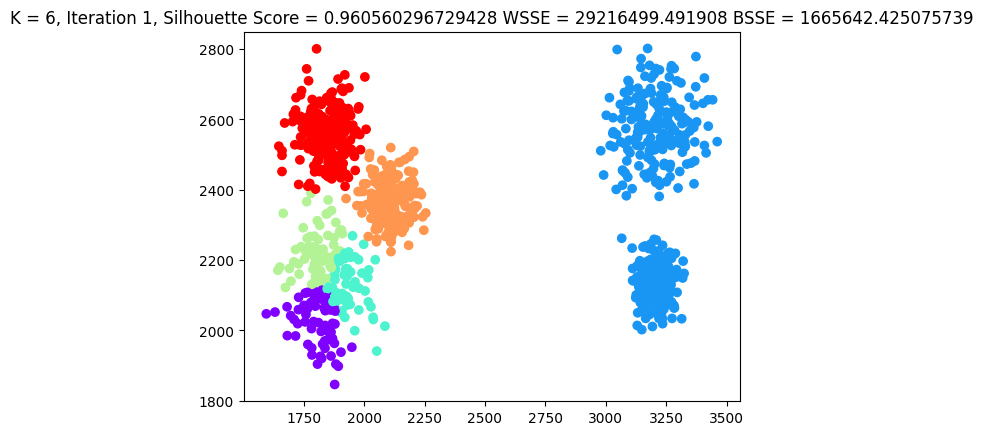

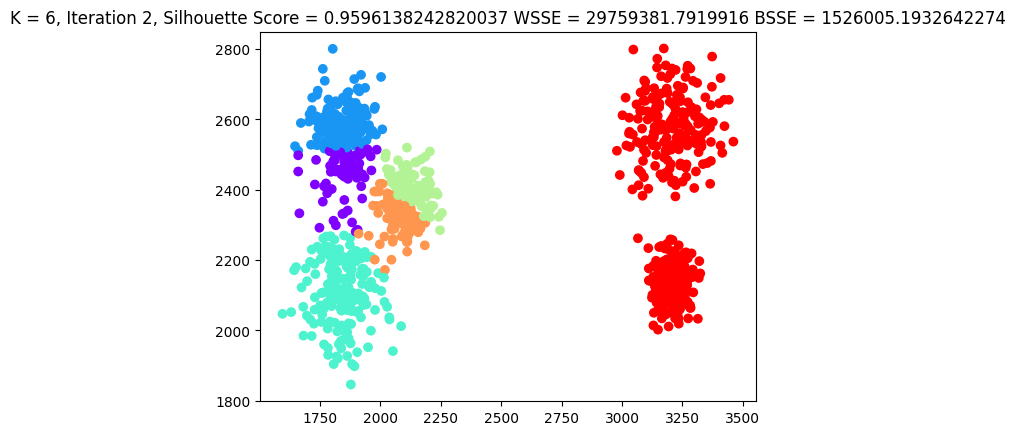

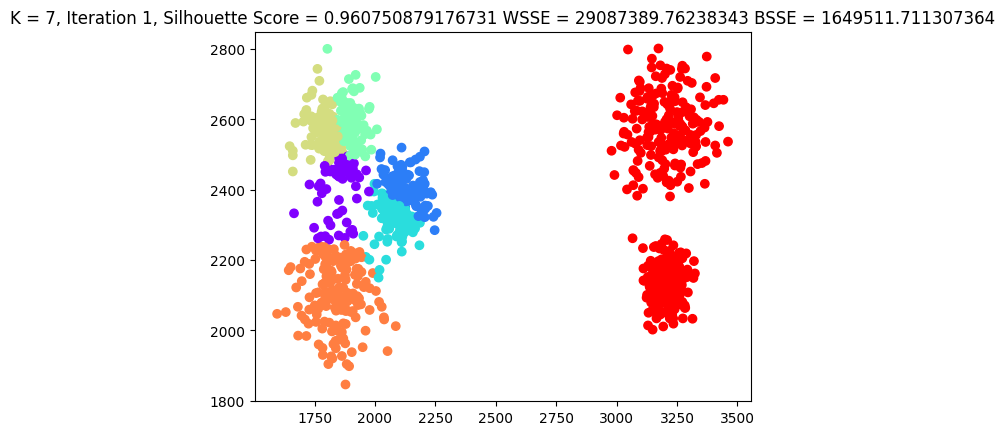

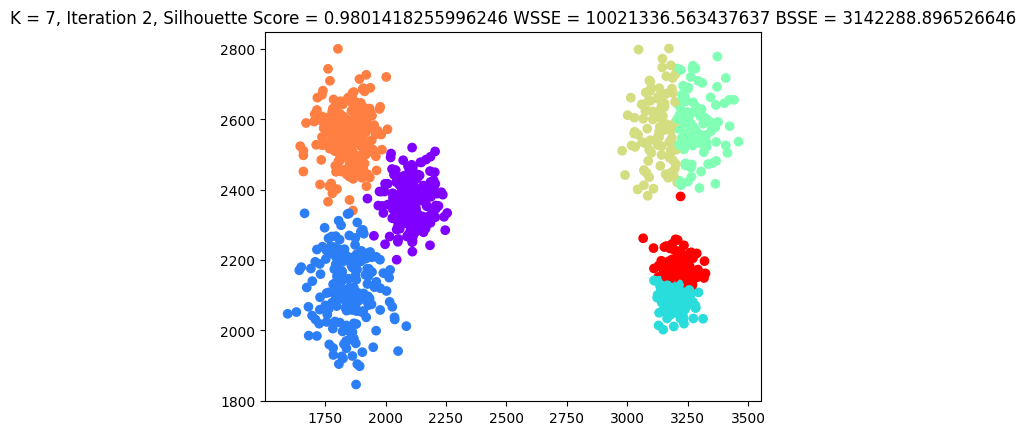

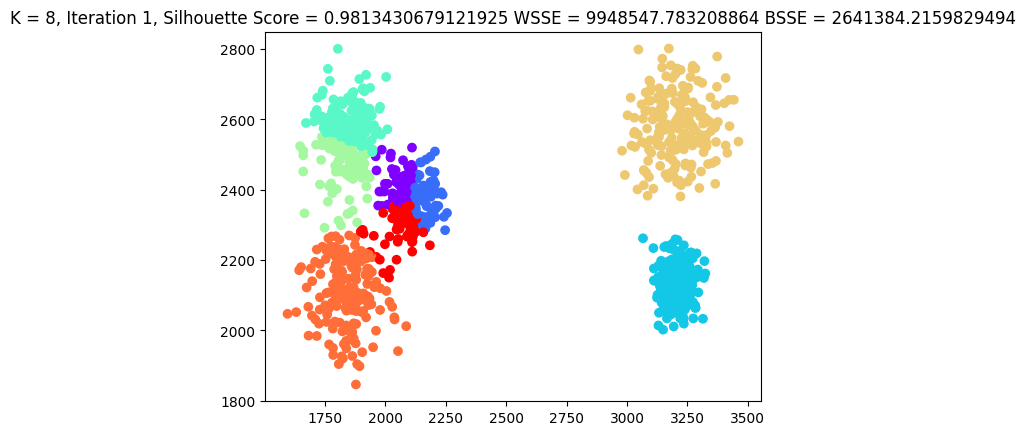

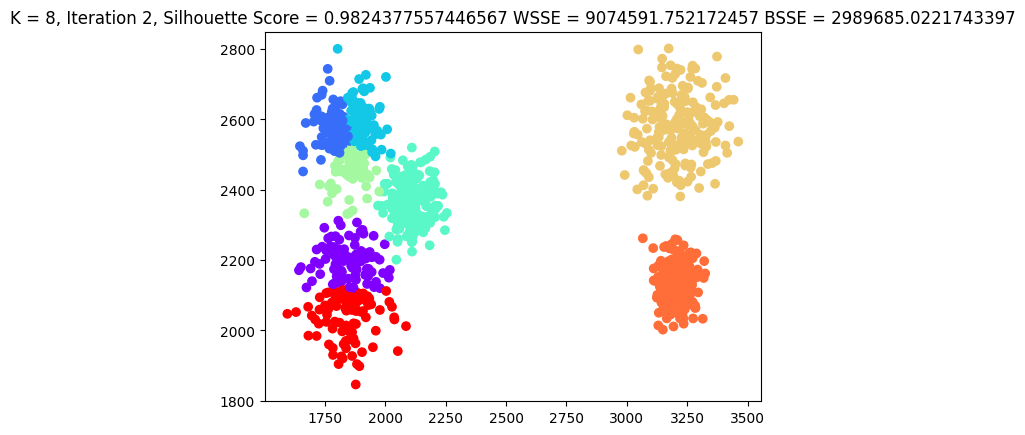

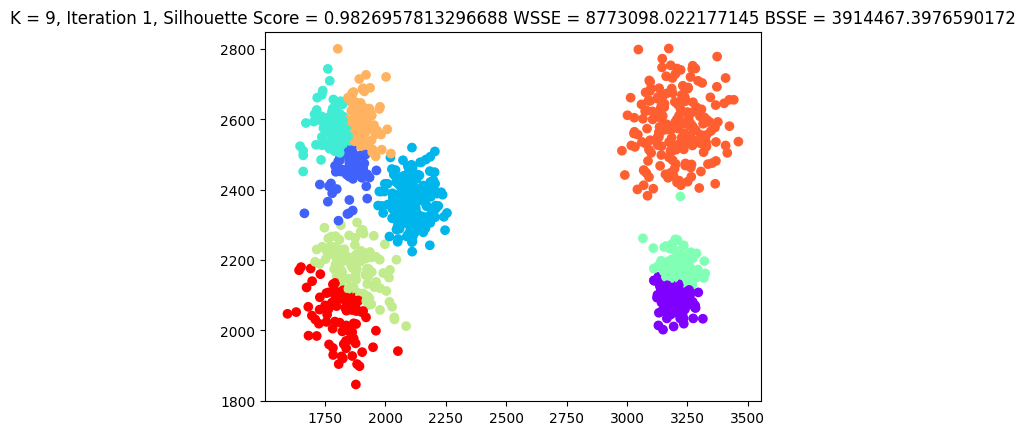

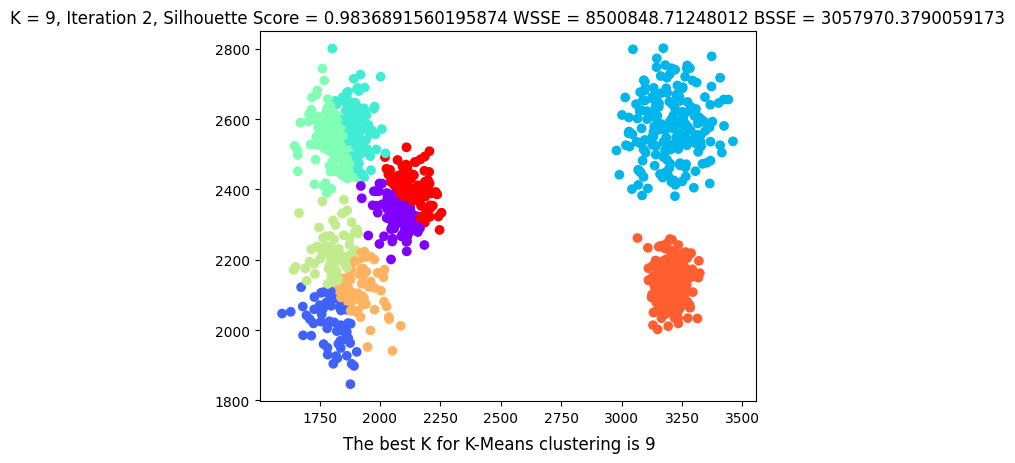

In [123]:
# K-Means Evaluation

max_score = float('-inf')
best_k = 1
for i in range(2, 10):
  for j in range(2):
    clustered, centroids = k_means(data, i)
    score = correct_silhouette(clustered, centroids)
    wsse = WSSE(clustered, centroids)
    bsse = BSSE(centroids)
    if score > max_score:
      max_score = score
      best_k =  i
    caption = ''
    if i == 9 and j == 1:
      caption = 'The best K for K-Means clustering is ' + str(best_k)
    visualize(clustered, 'K = ' + str(i) + ', Iteration ' + str(j + 1) + ', ' + 'Silhouette Score = ' + str(score) + ' WSSE = ' + str(wsse) + ' BSSE = ' + str(bsse), caption)

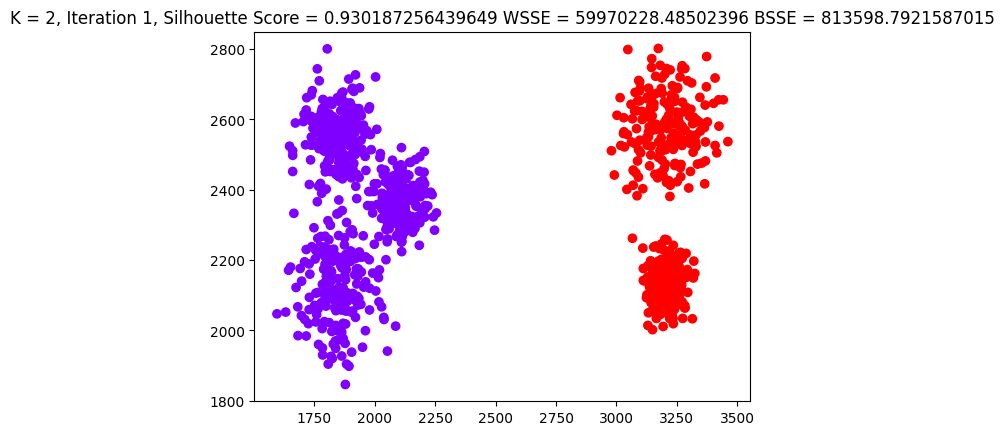

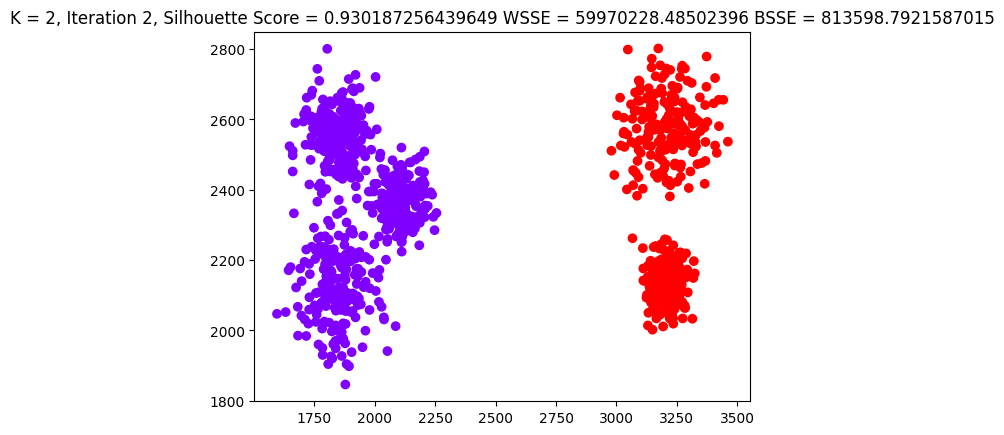

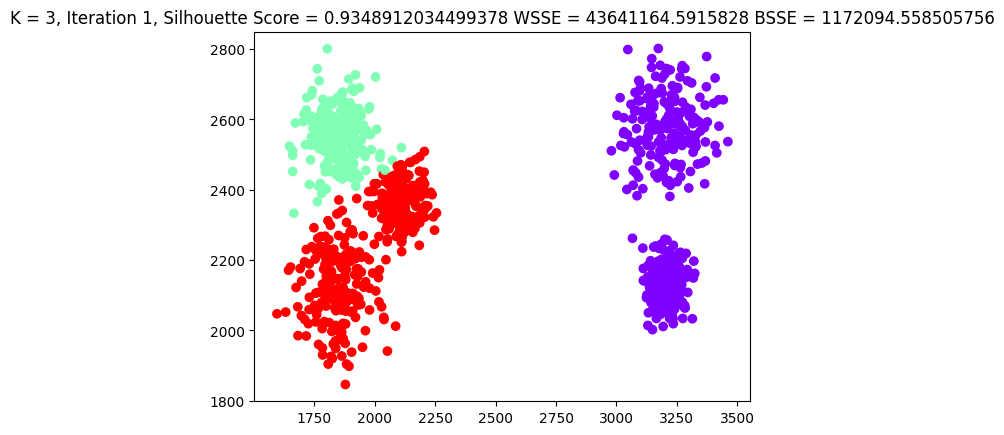

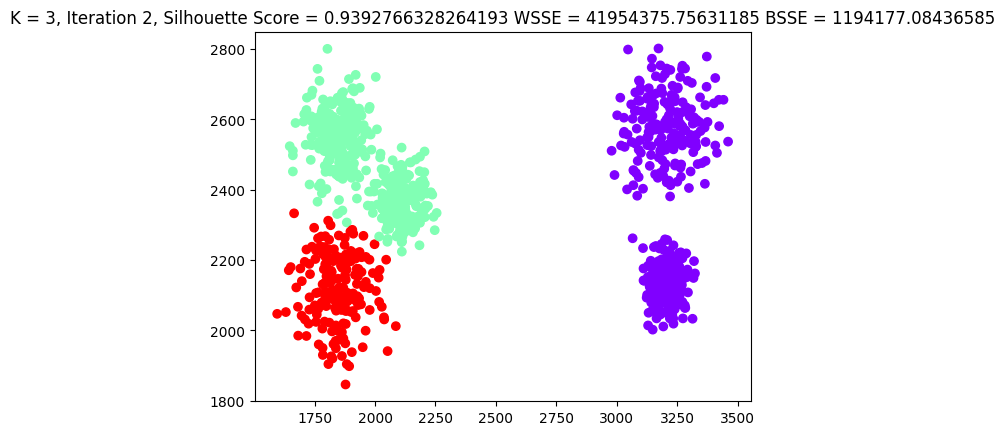

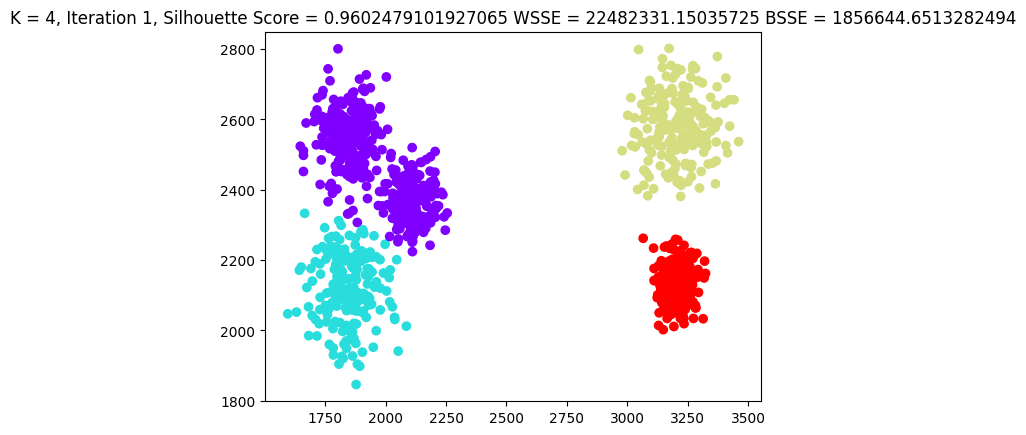

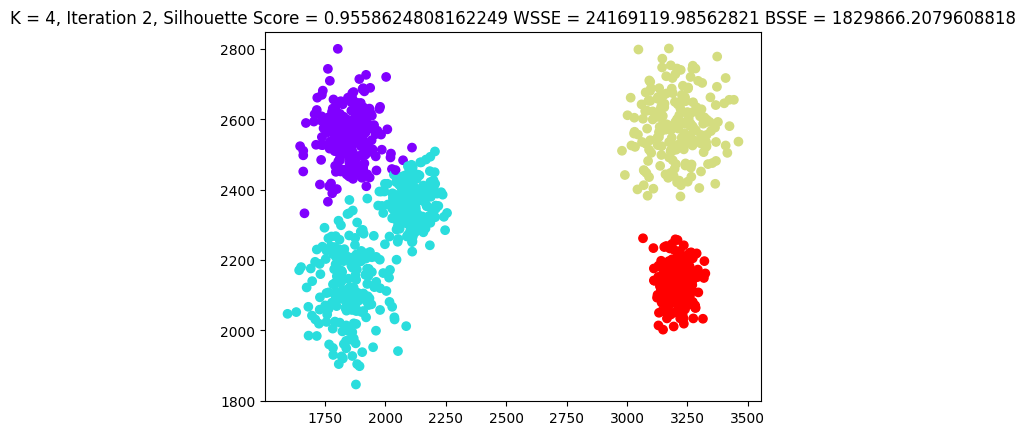

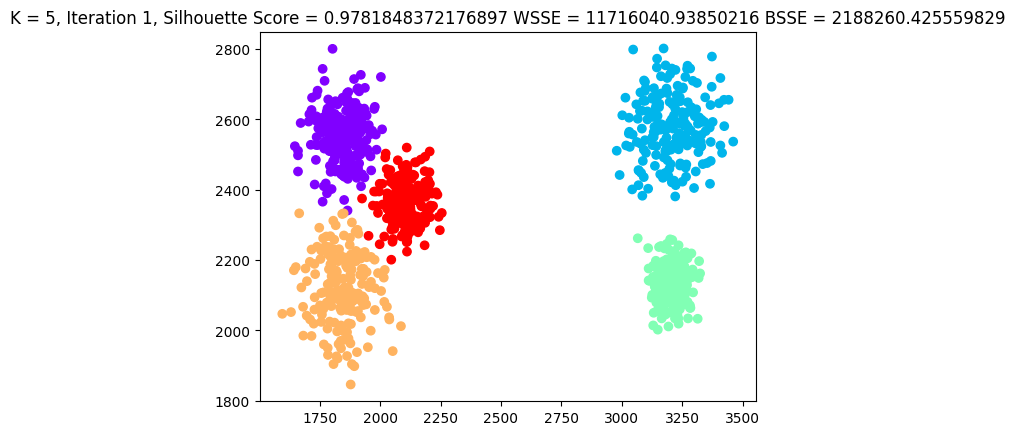

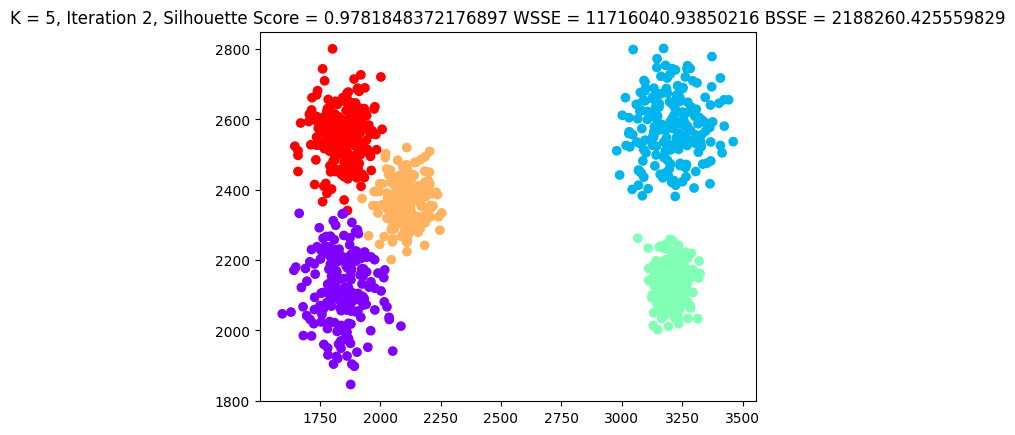

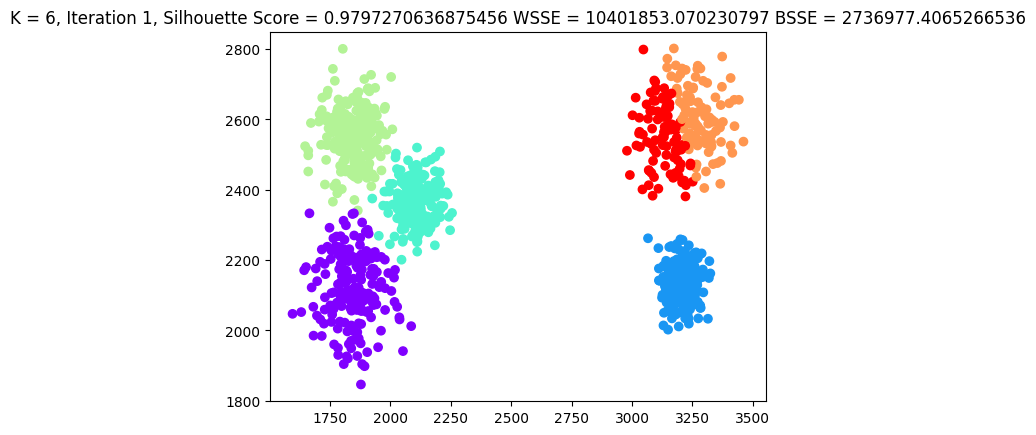

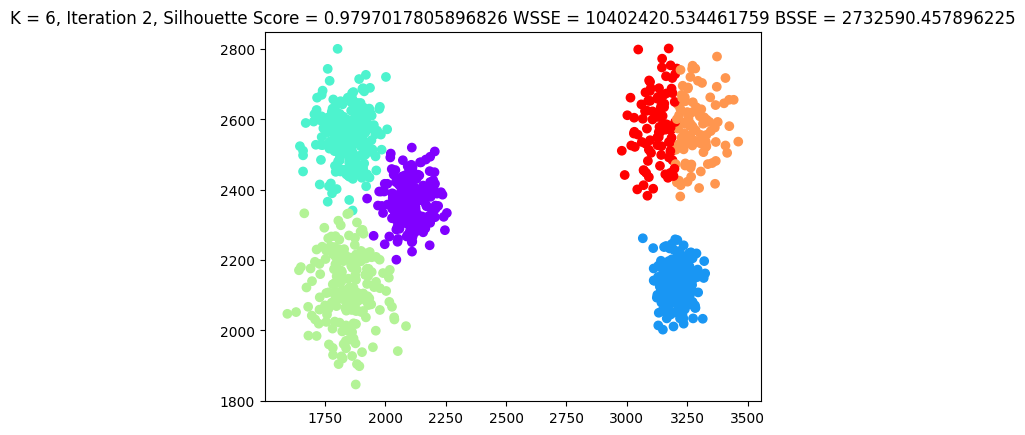

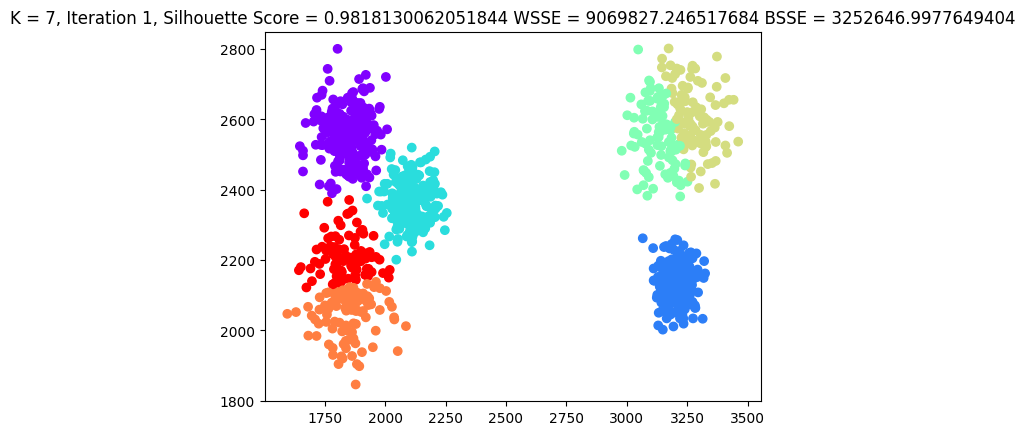

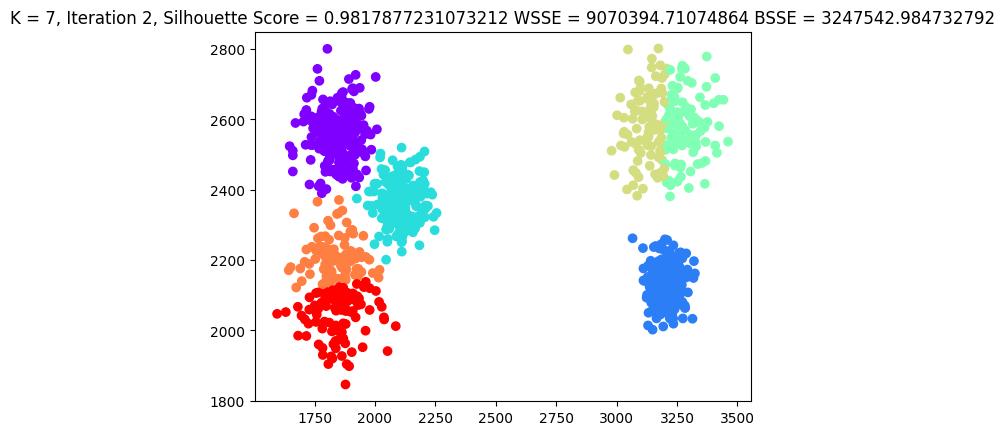

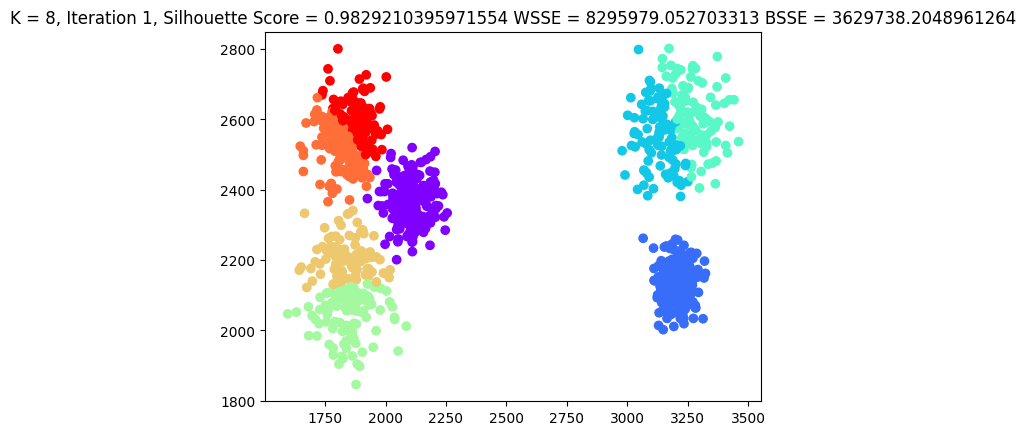

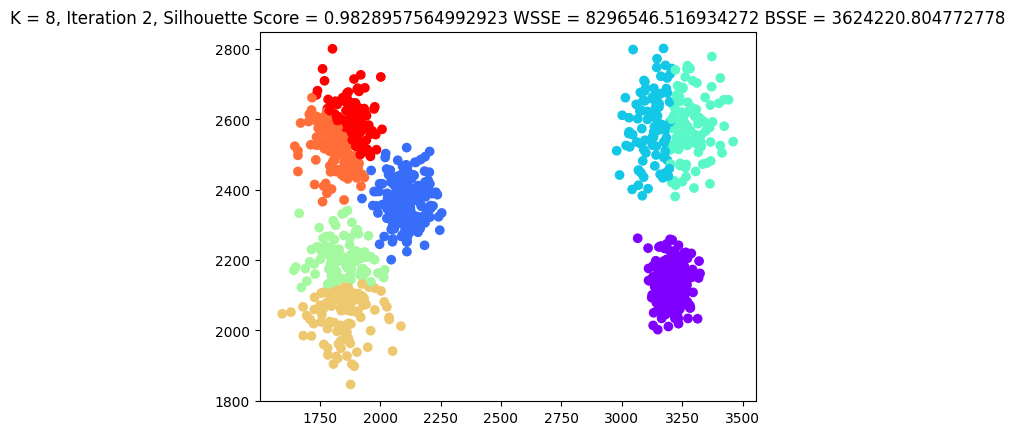

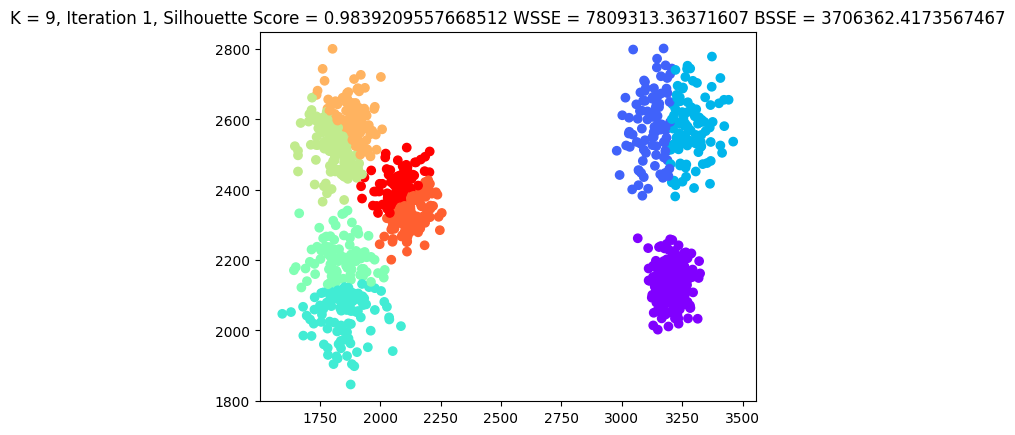

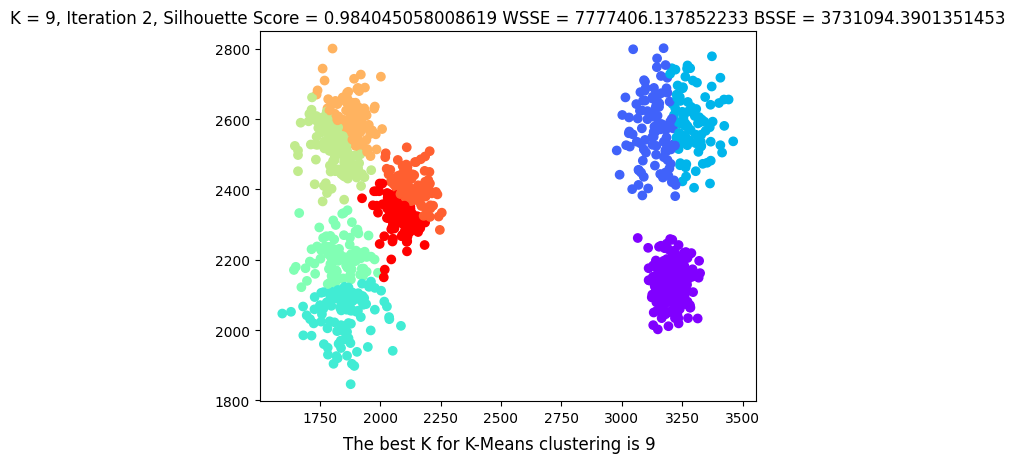

In [127]:
# Bisecting K-Means Evaluation

max_score = float('-inf')
best_k = 1
for i in range(2, 10):
  for j in range(2):
    clustered, centroids = bisecting_k_means(data, i)
    score = correct_silhouette(clustered, centroids)
    wsse = WSSE(clustered, centroids)
    bsse = BSSE(centroids)
    if score > max_score:
      max_score = score
      best_k =  i
    caption = ''
    if i == 9 and j == 1:
      caption = 'The best K for K-Means clustering is ' + str(best_k)
    visualize(clustered, 'K = ' + str(i) + ', Iteration ' + str(j + 1) + ', ' + 'Silhouette Score = ' + str(score) + ' WSSE = ' + str(wsse) + ' BSSE = ' + str(bsse), caption)

In [71]:
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
ss = SparkSession.builder.getOrCreate()

# dataset = ss.read.text("DS1.txt")
dataset = ss.read.text("DS2.txt")
dataset = dataset.rdd.map(lambda row: row.value.split(" ")).map(lambda row: [float(x) for x in row]).toDF(["feature1", "feature2"])
assembler = VectorAssembler(
    inputCols=["feature1", "feature2"],
    outputCol="features"
)
data_prepped = assembler.transform(dataset)
dataset.show()

+--------+--------+
|feature1|feature2|
+--------+--------+
|147265.0|351837.0|
|149905.0|349644.0|
|149479.0|351115.0|
|151985.0|353649.0|
|153457.0|349093.0|
|153508.0|350082.0|
|147269.0|357194.0|
|150245.0|348533.0|
|146161.0|352594.0|
|146479.0|352222.0|
|149978.0|354997.0|
|154847.0|352140.0|
|147566.0|342000.0|
|151174.0|347435.0|
|149287.0|351539.0|
|153533.0|351164.0|
|146556.0|355830.0|
|150103.0|354435.0|
|151747.0|351738.0|
|153480.0|350609.0|
+--------+--------+
only showing top 20 rows



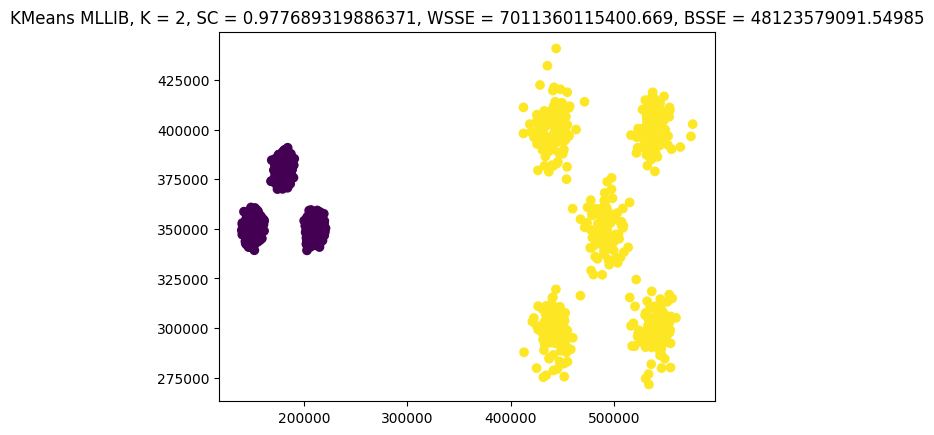

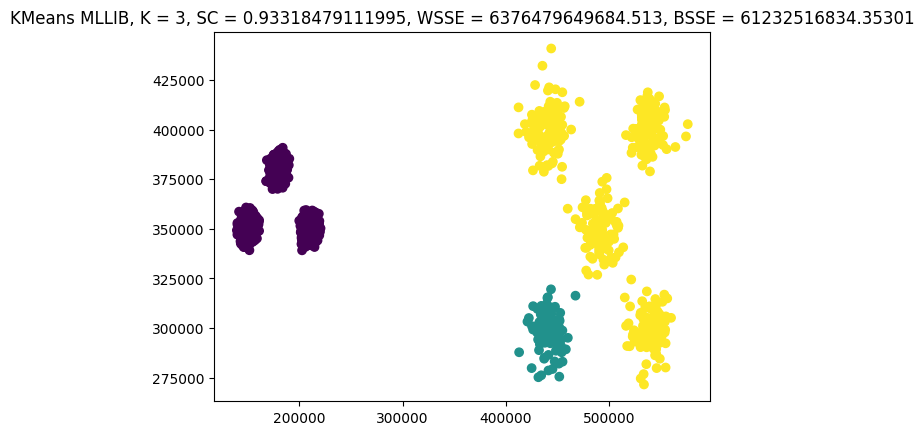

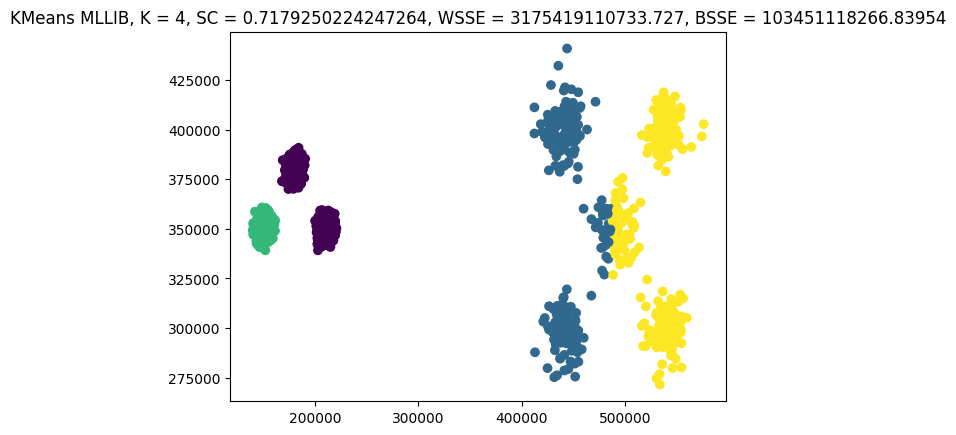

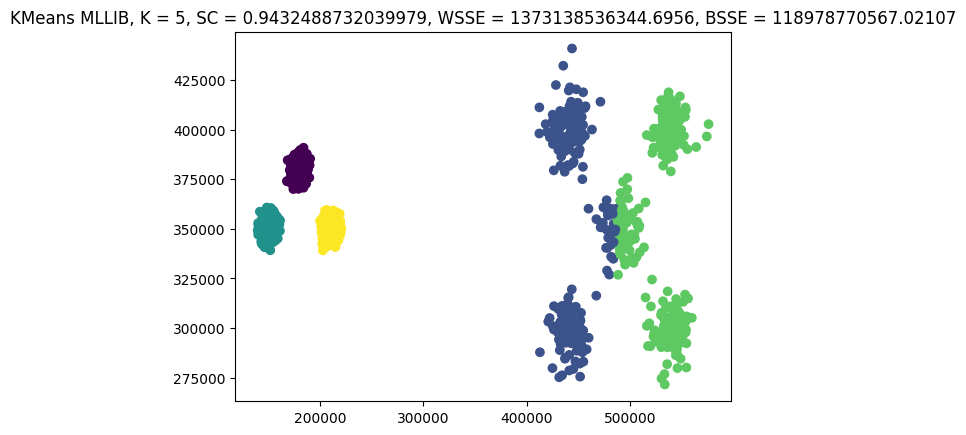

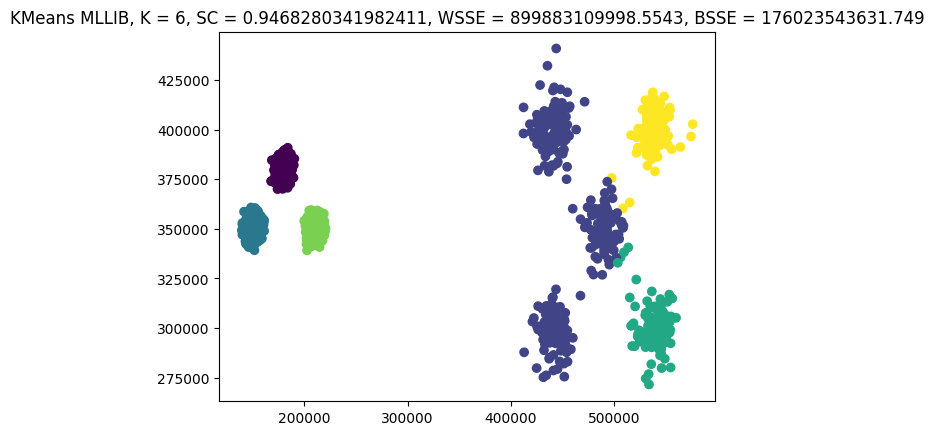

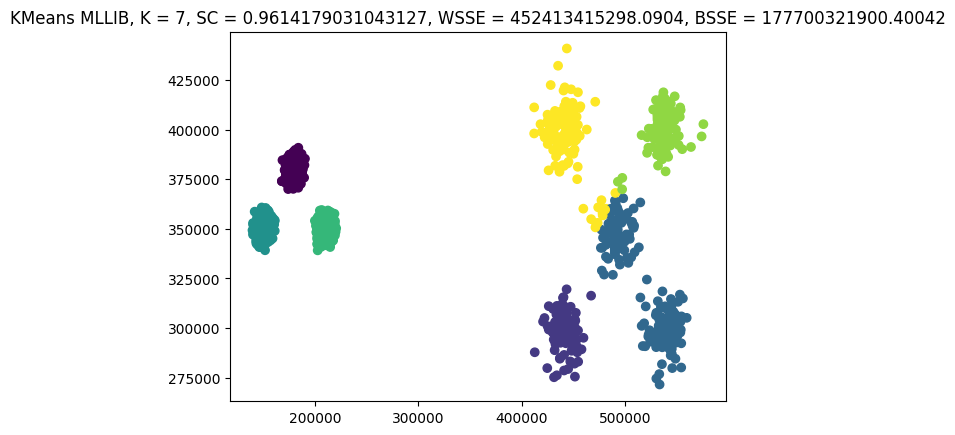

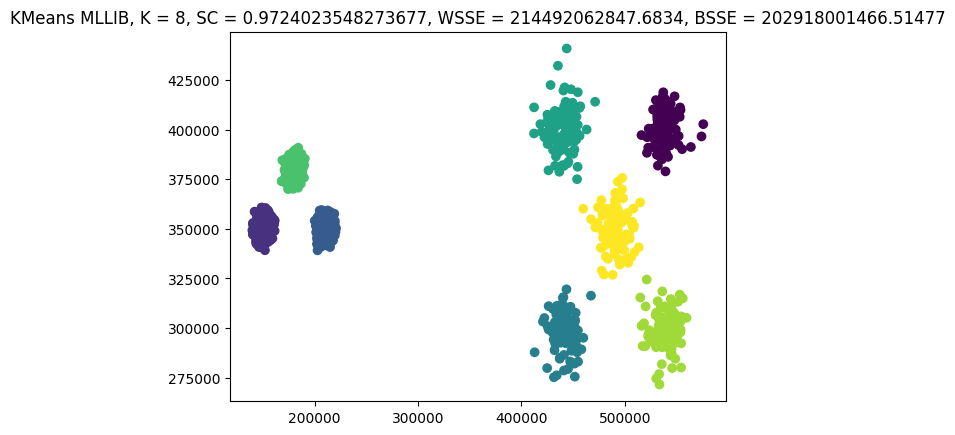

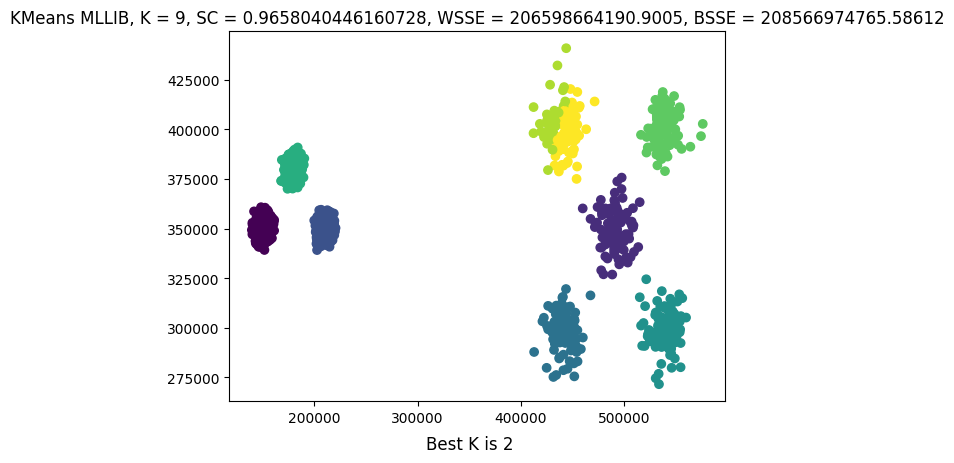

In [77]:
max_score = float('-inf')
best_k = -1

wsse_arr = [float('inf')]

for i in range(2, 10):
  kmeans = KMeans().setK(i)
  model = kmeans.fit(data_prepped.select("features"))
  predictions = model.transform(data_prepped)

  evaluator = ClusteringEvaluator()
  silhouette = evaluator.evaluate(predictions)

  wsse = model.summary.trainingCost
  wsse_arr.append(wsse)

  if silhouette > max_score:
      max_score = silhouette
      best_k = i

  centers = model.clusterCenters()
  overall_centroid = np.mean(np.array(centers), axis=0)
  bsse =  sum([np.linalg.norm(center - overall_centroid) ** 2 for center in centers])

  predictions_pd = predictions.select("features", "prediction").toPandas()
  predictions_pd['feature1'] = predictions_pd['features'].apply(lambda x: x[0])
  predictions_pd['feature2'] = predictions_pd['features'].apply(lambda x: x[1])

  plt.scatter(predictions_pd['feature1'], predictions_pd['feature2'], c=predictions_pd['prediction'], cmap='viridis', label='Data Points')
  plt.title('KMeans MLLIB, K = ' + str(i) + ', SC = ' + str(silhouette) + ', WSSE = ' + str(wsse) + ', BSSE = ' + str(bsse))

  if i == 9:
      plt.figtext(0.5, 0.01, 'Best K is ' + str(best_k), wrap=True, horizontalalignment='center', fontsize=12)

  plt.show()

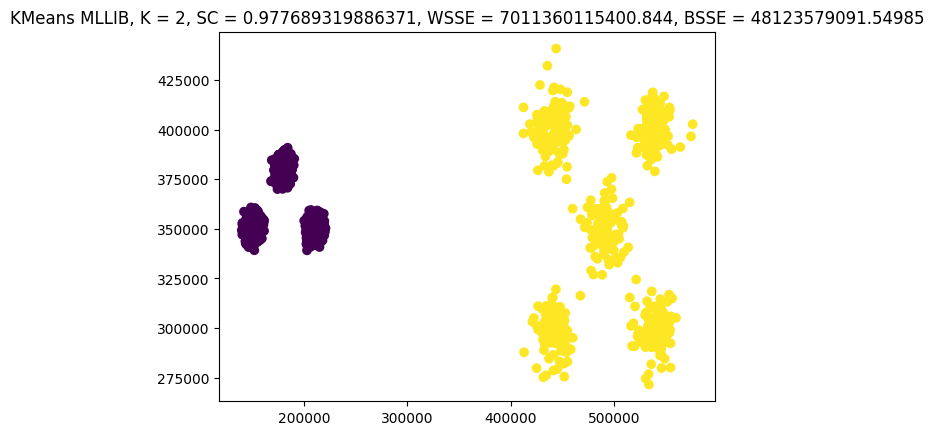

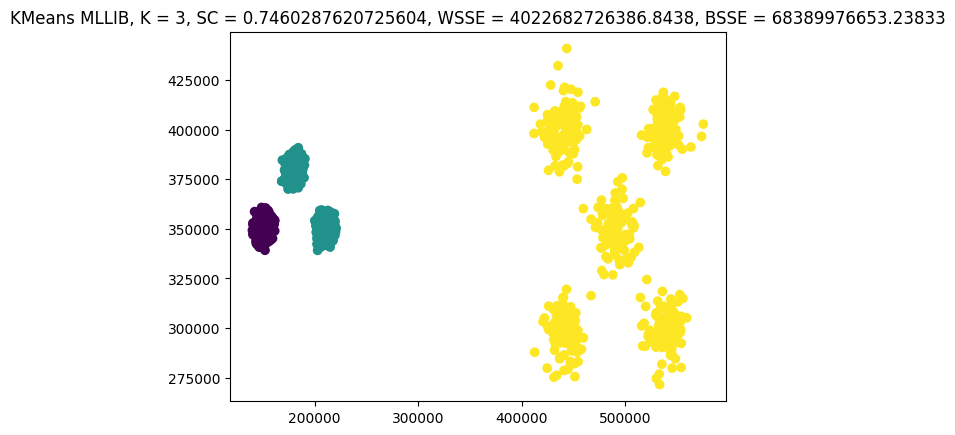

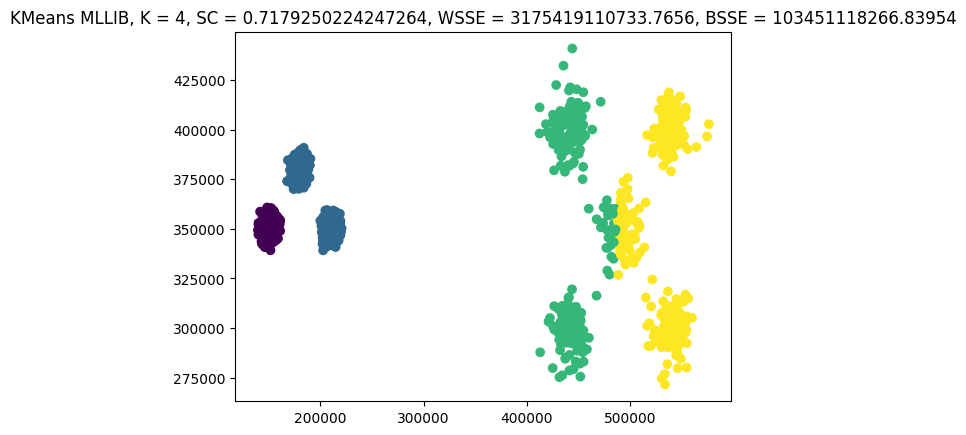

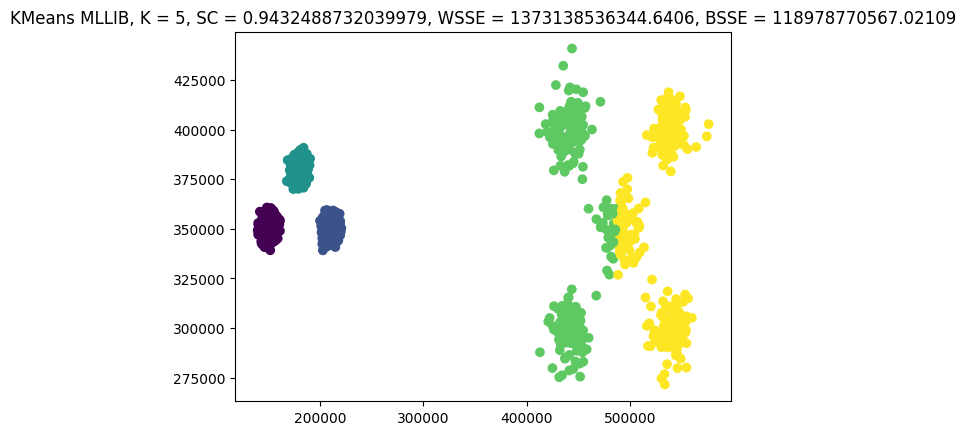

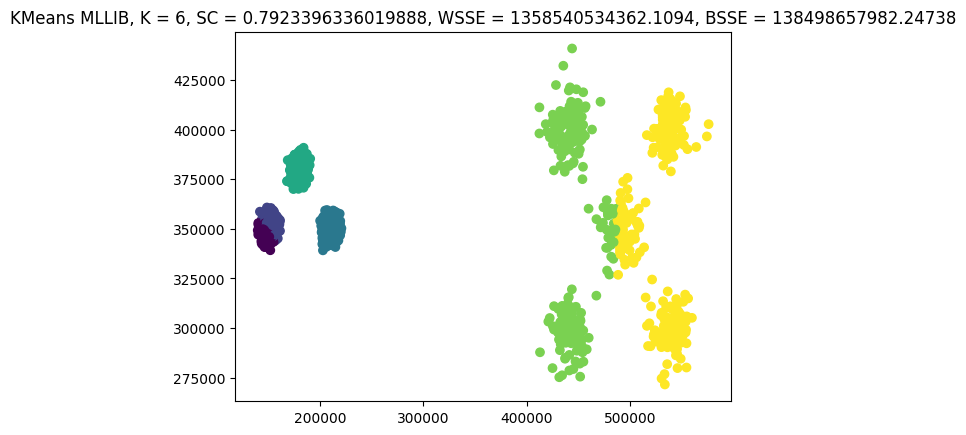

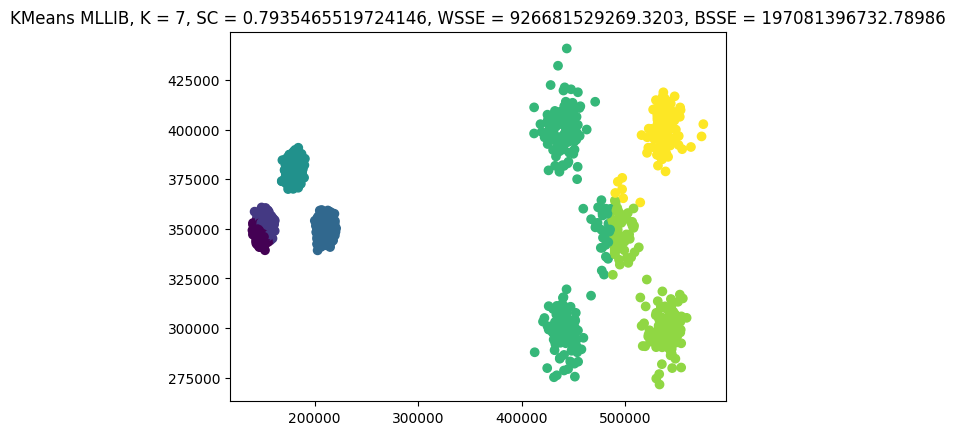

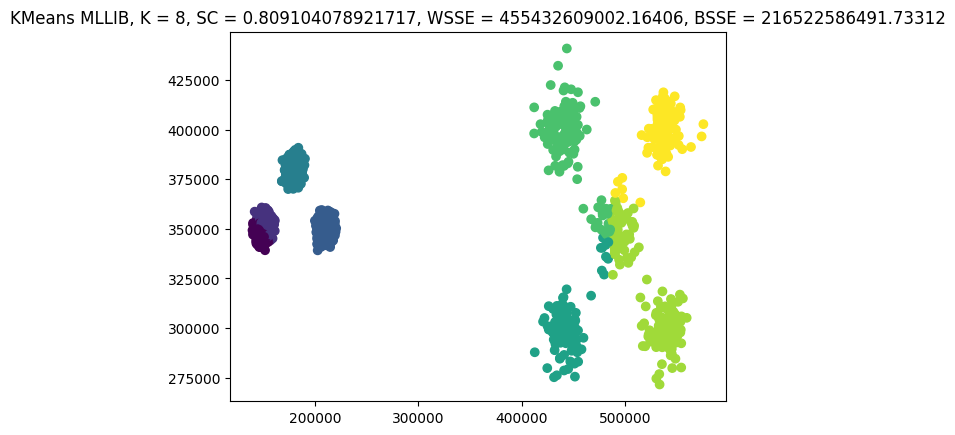

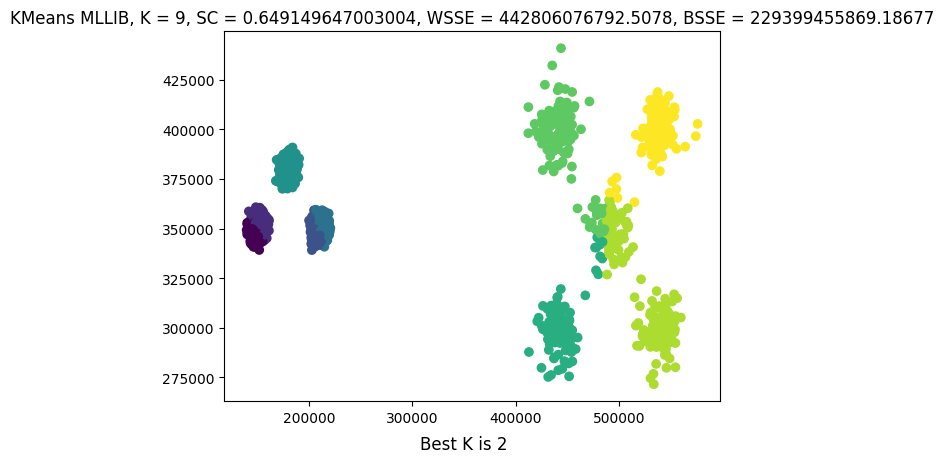

In [79]:
max_score = float('-inf')
best_k = -1

wsse_arr = [float('inf')]

for i in range(2, 10):
  kmeans = BisectingKMeans(k=i, minDivisibleClusterSize=1.0)
  model = kmeans.fit(data_prepped.select("features"))  # Select only the "features" column
  predictions = model.transform(data_prepped)

  evaluator = ClusteringEvaluator()
  silhouette = evaluator.evaluate(predictions)

  wsse = model.summary.trainingCost
  wsse_arr.append(wsse)

  if silhouette > max_score:
      max_score = silhouette
      best_k = i

  centers = model.clusterCenters()
  overall_centroid = np.mean(np.array(centers), axis=0)
  bsse =  sum([np.linalg.norm(center - overall_centroid) ** 2 for center in centers])

  predictions_pd = predictions.select("features", "prediction").toPandas()
  predictions_pd['feature1'] = predictions_pd['features'].apply(lambda x: x[0])
  predictions_pd['feature2'] = predictions_pd['features'].apply(lambda x: x[1])

  plt.scatter(predictions_pd['feature1'], predictions_pd['feature2'], c=predictions_pd['prediction'], cmap='viridis', label='Data Points')
  plt.title('KMeans MLLIB, K = ' + str(i) + ', SC = ' + str(silhouette) + ', WSSE = ' + str(wsse) + ', BSSE = ' + str(bsse))

  if i == 9:
      plt.figtext(0.5, 0.01, 'Best K is ' + str(best_k), wrap=True, horizontalalignment='center', fontsize=12)

  plt.show()

In [80]:
# Post Processing

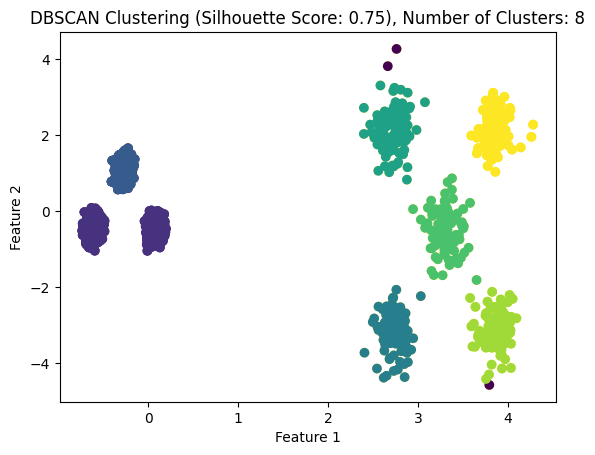

In [69]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import BisectingKMeans, KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
df = dataset

feature_columns = [c for c in df.columns if c.startswith('feature')]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaled_data = scaler.fit(data).transform(data)
kmeans = KMeans().setK(2)
kmeans_model = kmeans.fit(scaled_data)
kmeans_predictions = kmeans_model.transform(scaled_data)
features_array = np.array(scaled_data.select("scaledFeatures").rdd.map(lambda x: x[0].toArray()).collect())
eps = 0.5
min_samples = 14
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(features_array)
kmeans_predictions_pd = kmeans_predictions.select("scaledFeatures", "prediction").toPandas()
kmeans_predictions_pd['feature1'] = kmeans_predictions_pd['scaledFeatures'].apply(lambda x: x[0])
kmeans_predictions_pd['feature2'] = kmeans_predictions_pd['scaledFeatures'].apply(lambda x: x[1])
silhouette_kmeans = silhouette_score(features_array, kmeans_predictions_pd['prediction'])
num_clusters_dbscan = len(np.unique(dbscan.labels_))
plt.scatter(kmeans_predictions_pd['feature1'], kmeans_predictions_pd['feature2'], c=kmeans_predictions_pd['prediction'], cmap='viridis', label='K-means Clusters')
plt.scatter(features_array[:, 0], features_array[:, 1], c=dbscan.labels_, cmap='viridis')
plt.title(f'DBSCAN Clustering (Silhouette Score: {silhouette_kmeans:.2f}), Number of Clusters: {num_clusters_dbscan}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

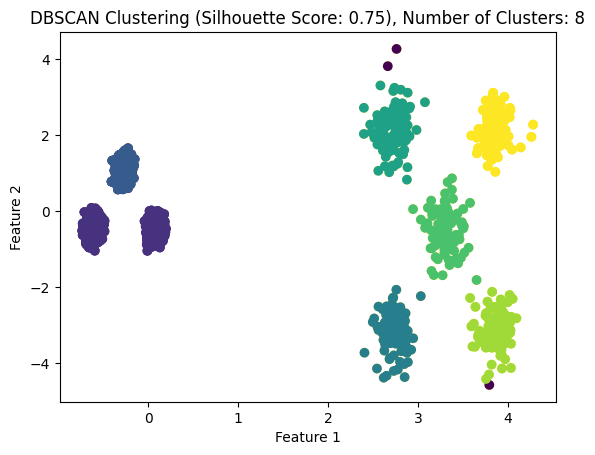

In [68]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import BisectingKMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
df = dataset

feature_columns = [c for c in df.columns if c.startswith('feature')]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(df)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
scaled_data = scaler.fit(data).transform(data)
kmeans = BisectingKMeans(k=2, minDivisibleClusterSize=1.0)
kmeans_model = kmeans.fit(scaled_data)
kmeans_predictions = kmeans_model.transform(scaled_data)
features_array = np.array(scaled_data.select("scaledFeatures").rdd.map(lambda x: x[0].toArray()).collect())
eps = 0.5
min_samples = 14
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan.fit(features_array)
kmeans_predictions_pd = kmeans_predictions.select("scaledFeatures", "prediction").toPandas()
kmeans_predictions_pd['feature1'] = kmeans_predictions_pd['scaledFeatures'].apply(lambda x: x[0])
kmeans_predictions_pd['feature2'] = kmeans_predictions_pd['scaledFeatures'].apply(lambda x: x[1])
silhouette_kmeans = silhouette_score(features_array, kmeans_predictions_pd['prediction'])
num_clusters_dbscan = len(np.unique(dbscan.labels_))
plt.scatter(kmeans_predictions_pd['feature1'], kmeans_predictions_pd['feature2'], c=kmeans_predictions_pd['prediction'], cmap='viridis', label='K-means Clusters')
plt.scatter(features_array[:, 0], features_array[:, 1], c=dbscan.labels_, cmap='viridis')
plt.title(f'DBSCAN Clustering (Silhouette Score: {silhouette_kmeans:.2f}), Number of Clusters: {num_clusters_dbscan}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()